In [292]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')

import numpy as np
import matplotlib.pyplot as plt
import SolveLinSys
from utilities import compute_derivatives_2d, find_nearest_value
from numba import njit

Equation:

\begin{align}
0 = \max_e \min_{h2} &-\delta \phi(y,z_2) + \delta\eta\log e + \xi_m \frac{(h_2)^2}{2} + \frac{\partial \phi}{\partial y}(y, z_2) e\\
&+ \left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\left[-\rho(z_2 - \mu_2) + \sqrt{z_2}\sigma_2 h_2\right] + \left[\frac{\partial^2 \phi}{\partial (z_2)^2}(y, z_2)\right]\left(\frac{z_2|\sigma_2|^2}{2}\right)\\
& + (\eta-1)\left(\left[\tau_1 + \tau_2(yz_2)\right]\left(z_2 e+y[-\rho(z_2-\mu_2)]+ y\sqrt{z_2}\sigma_2h_2\right) + \frac{\tau_2 z_2}{2}y^2|\sigma_2|^2\right)
\end{align}

FOC of $h_2$ gives : 

$$
h_2^* = -\frac{\left[\frac{\partial \phi}{\partial z_2}(y, z_2)\right]\sqrt{z_2}\sigma_2 + (\eta-1)\left[\tau_1 + \tau_2(yz_2)\right]\left(y\sqrt{z_2}\sigma_2\right)}{\xi_m}
$$

FOC of $e$ gives :

$$
e^* = -\frac{\delta \eta}{\frac{\partial \phi}{\partial y}(y, z_2) + (\eta-1)\left[\tau_1+\tau_2(yz_2)\right]z_2}
$$

In [355]:
def false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ε=.3, tol=-10):
    A = A.reshape(-1, 1, order='F')
    B = np.hstack([B_z.reshape(-1, 1, order='F'), B_y.reshape(-1, 1, order='F')])
    C = np.hstack([C_zz.reshape(-1, 1, order='F'), C_yy.reshape(-1, 1, order='F')])
    D = D.reshape(-1, 1, order='F')
    v0 = v0.reshape(-1, 1, order='F')
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)
    return out


def false_transient(z_grid, y_grid, model_paras=(), v0=None, ϵ=.5, tol=1e-8, max_iter=10_000):
    η, ξ_m, δ, η, μ_2, ρ, σ_2, τ_1, τ_2, τ_2p, τ_bar = model_paras

    Δ_z = z_grid[1] - z_grid[0]
    Δ_y = y_grid[1] - y_grid[0]
    (z_mat, y_mat) = np.meshgrid(z_grid, y_grid, indexing = 'ij')
    stateSpace = np.hstack([z_mat.reshape(-1, 1, order='F'), y_mat.reshape(-1, 1, order='F')])

    if v0 is None:
        v0 = -δ*η*y_mat

    count = 1
    error = 1.

    while error > tol and count < max_iter:
        v_old = v0.copy()
        v0_dz = compute_derivatives_2d(v0, 0, 1, Δ_z)
        v0_dzz = compute_derivatives_2d(v0, 0, 2, Δ_z)
        v0_dy = compute_derivatives_2d(v0, 1, 1, Δ_y)

        e = - δ*η / (v0_dy + (η-1)*(τ_1+τ_2*y_mat*z_mat+τ_2p*(y_mat*z_mat>τ_bar)*(y_mat*z_mat-τ_bar))*z_mat)
        e[e<=0] = 1e-10
        h = - (v0_dz + (η-1)*(τ_1+τ_2*y_mat*z_mat+τ_2p*(y_mat*z_mat>τ_bar)*(y_mat*z_mat-τ_bar))*y_mat)*np.sqrt(z_mat)*σ_2 / ξ_m
        
        A = np.ones_like(z_mat)*(-δ)
        B_z = -ρ*(z_mat - μ_2) + np.sqrt(z_mat)*σ_2*h
        B_y = e
        C_zz = z_mat*σ_2**2/2
        C_yy = np.zeros_like(z_mat)
        D = δ*η*np.log(e) + ξ_m*h**2/2 + (η-1)*((τ_1+τ_2*y_mat*z_mat+τ_2+τ_2p*(y_mat*z_mat>τ_bar))
                                                *(z_mat*e + y_mat*(-ρ*(z_mat-μ_2)) 
                                                  + y_mat*np.sqrt(z_mat)*σ_2*h)
                                                + (τ_2+τ_2p*(y_mat*z_mat>τ_bar))*z_mat/2*y_mat**2*σ_2**2)

        res = false_transient_one_iteration(stateSpace, A, B_z, B_y, C_zz, C_yy, D, v0, ϵ) # CG tol = 1e-10
        v0 = res[2].reshape(v0.shape, order = "F")

        rhs_error = A*v0 + B_z*v0_dz + B_y*v0_dy + C_zz*v0_dzz + D
        rhs_error = np.max(abs(rhs_error))
        lhs_error = np.max(abs((v0 - v_old)/ϵ))
        error = lhs_error

        print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
        count += 1
    print("Iteration %s: LHS Error: %s; RHS Error %s" % (count, lhs_error, rhs_error))
    return v0, e

In [364]:
# Model parameters
η = .032
# ξ_m = .00256
ξ_m = 1000.
δ = .01
# Z process
μ_2 = 1.86/1000.
ρ = 0.9
σ_2 = np.sqrt(2*ρ/10416.29)/2
# Damage setting
τ_1 = 1.7675/10000
τ_2 = 0.0022*2
τ_2p = 0.0197*2
# τ_2p = 0.3853*2
τ_bar = 2.

pde_paras = (η, ξ_m, δ, η, μ_2, ρ, σ_2, τ_1, τ_2, τ_2p, τ_bar)

# Capital and z parameters
α_k = -0.043
β_k = 0.04
σ_k = np.array([0.477*2, 0])/100.
β_z = 0.014*4
σ_z = np.array([0.011*2, 0.025*2])
α = 0.115
ioverk = 0.09
κ = 6.667

# Grid setting
n_z = 200
z_min = np.max([μ_2 - 3*np.sqrt(σ_2**2*μ_2/(2*ρ)), 1e-9])
z_max = μ_2 + 3*np.sqrt(σ_2**2*μ_2/(2*ρ))
z_grid = np.linspace(z_min, z_max, n_z)

n_y = 20
y_min = 1e-2
y_max = 3000.
y_grid = np.linspace(y_min, y_max, n_y)

In [365]:
ϕ_grid, e_grid = false_transient(z_grid, y_grid, model_paras=pde_paras,
                                 v0=None, ϵ=.5, tol=1e-8, max_iter=10_000)

Iteration 1: LHS Error: 0.07627686010561274; RHS Error 0.1155487233044189
Iteration 2: LHS Error: 0.052511822657161256; RHS Error 0.07605926873090825
Iteration 3: LHS Error: 0.03809687043427834; RHS Error 0.05232126072067464
Iteration 4: LHS Error: 0.02790028226096153; RHS Error 0.03795731418496
Iteration 5: LHS Error: 0.02073745638965141; RHS Error 0.02779673262675339
Iteration 6: LHS Error: 0.01572952932446192; RHS Error 0.020658921729635946
Iteration 7: LHS Error: 0.01223977434730994; RHS Error 0.015668415662141624
Iteration 8: LHS Error: 0.009813034565945955; RHS Error 0.012190774872341631
Iteration 9: LHS Error: 0.008127231805554747; RHS Error 0.009787899499093977
Iteration 10: LHS Error: 0.006956135769194738; RHS Error 0.008124377322981144
Iteration 11: LHS Error: 0.0061416968978509345; RHS Error 0.006968742258904662
Iteration 12: LHS Error: 0.005573937314012678; RHS Error 0.006165016207588289
Iteration 13: LHS Error: 0.005176557535789161; RHS Error 0.005604689767549048
Iteration

Iteration 106: LHS Error: 0.004238990971971002; RHS Error 0.0030306864334922806
Iteration 107: LHS Error: 0.0041129602337369175; RHS Error 0.0038833733000560957
Iteration 108: LHS Error: 0.004319633179394711; RHS Error 0.005083445040932168
Iteration 109: LHS Error: 0.003552407415274017; RHS Error 0.005512492955906416
Iteration 110: LHS Error: 0.00382914443381277; RHS Error 0.016135709493406473
Iteration 111: LHS Error: 0.002902276034119994; RHS Error 0.06003964585479558
Iteration 112: LHS Error: 0.002875740844671515; RHS Error 0.05279353355311213
Iteration 113: LHS Error: 0.002746682251699273; RHS Error 0.13449111213225468
Iteration 114: LHS Error: 0.01682591830170349; RHS Error 0.8290358565395834
Iteration 115: LHS Error: 0.013251648525583887; RHS Error 0.9441622208906982
Iteration 116: LHS Error: 0.00910055773538554; RHS Error 0.04976432826613106
Iteration 117: LHS Error: 0.004456004280112613; RHS Error 0.07836486158458957
Iteration 118: LHS Error: 0.003143759780976113; RHS Error 0.1

KeyboardInterrupt: 

In [334]:
@njit(parallel=True)
def simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=100):
    Et = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = np.interp(y_start, y_grid, e_grid[z_loc])
        y_start = y_start + Et[i]
    return Et


@njit(parallel=True)
def simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=100_000, T=100, dt=1.):
    var_z = dt*σ_z@σ_z/(1-(1-β_z*dt)**2)
    std_z = np.sqrt(var_z)

    time_periods = int(T/dt)
    z_path = np.zeros((N, time_periods+1))
    k_path = np.zeros((N, time_periods+1))
    for i in range(N):
        z0 = np.random.normal(0.,std_z)
        k0 = k_start
        z_path[i, 0] = z0
        k_path[i, 0] = k0
        for j in range(1, time_periods+1):
            k1 = k0 + (α_k + β_k*z0 + ioverk - κ/2.*ioverk**2 - σ_k@σ_k/2.)*dt + σ_k@Ws[i, j]*np.sqrt(dt)
            z1 = (1.-β_z*dt)*z0 + σ_z@Ws[i, j]*np.sqrt(dt)
            k_path[i, j] = k1
            z_path[i, j] = z1
            k0 = k1
            z0 = z1
    return k_path

In [337]:
e_grid_old = np.load('emission_grid.npy')

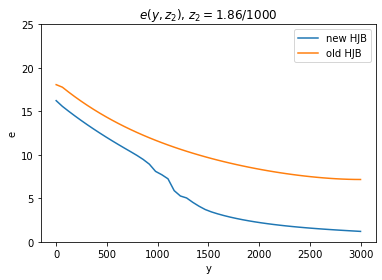

In [339]:
plt.plot(y_grid, e_grid[25], label='new HJB')
plt.plot(y_grid, e_grid_old[25], label='old HJB')
plt.ylim(0, 25)
plt.legend()
plt.title(r'$e(y, z_2)$, $z_2=1.86/1000$')
plt.xlabel('y')
plt.ylabel('e')
plt.savefig('plot.pdf')

In [335]:
T = 100
Et = simulate_emission(e_grid, y_grid, y_start=290, z_loc=25, T=T)

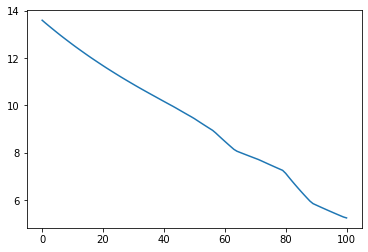

In [336]:
plt.plot(Et)

In [20]:
T = 100
N = 1_000_000
dt = 1.
k_start = np.log(80/α)
Ws = np.random.multivariate_normal(np.zeros(2), np.eye(2), (N, int(T/dt)))
logk_path = simulate_capital(α_k, β_k, σ_k, β_z, σ_z, ioverk, κ, Ws, k_start, N=N, T=T, dt=dt)
Kt = np.percentile(np.exp(logk_path), 50, axis=0)

In [21]:
SCCt = η*(α-ioverk)*Kt/((1.-η)*Et)
# SCCt = η*(0.025)*Kt/((1.-η)*Et)

Text(0.5, 0, 'Year')

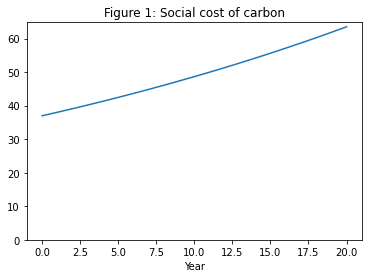

In [123]:
plt.plot(SCCt[:21]*1000)
plt.ylim(0, None)
plt.title('Figure 1: Social cost of carbon')
plt.xlabel('Year')
# plt.savefig('figure_1.pdf')

In [61]:
import pickle
with open('scc_bhh.pkl', 'rb') as f:
    scc_bhh = pickle.load(f)
with open('emission.pkl', 'rb') as f:
    emission_bbh = pickle.load(f)

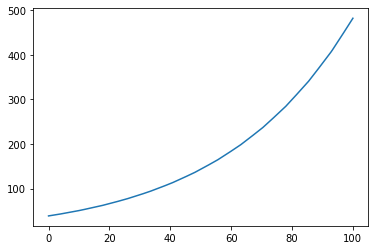

In [40]:
plt.plot(scc_bhh[0]['x'], scc_bhh[0]['y'])

In [45]:
scc_low = np.array([scc_bhh[0]['y'][4*i] for i in range(21)])

### SCC formula

$$
SCC = \frac{\eta\left[\color{red}{\alpha - \left(\frac{i}{k}\right)^*}\right]K_t^*}{(1-\eta)E_t^*}
$$

(1) in BBH, $\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.025$.

(2) in the new paper, $\alpha=0.2, \left(\frac{i}{k}\right)^*=0.125$, so $\left[\alpha - \left(\frac{i}{k}\right)^*\right]=0.075$.

### Adjustment cost parameters

$\alpha=0.115, \left(\frac{i}{k}\right)^*=0.09$

From FOC of $\frac{i}{k}$, we have:
$$
1-\kappa \left(\frac{i}{k}\right)^* - \frac{\delta}{\alpha-\left(\frac{i}{k}\right)^*} = 0 
$$

Therefore $\kappa=6.667$

### Log damage evolution

$$
d\log N_t = \left[\frac{d}{d\tau}\Lambda(Z_{2,t} F_t)[E_tZ_t-\rho(Z_{2,t}-\mu_2)F_t]+\frac{1}{2}\frac{d^2}{d\tau^2}\Lambda(Z_{2,t}F_t)Z_{2,t}F_t^2\sigma_2^2\right]dt + \frac{d}{d\tau} \Lambda(Z_{2,t}F_t)F_t\sqrt{Z_{2,t}}\sigma_zdW_t
$$

where

$$
dZ_t^2 = -\rho(Z_t^2 - \mu_2) dt + \sqrt{Z_t^2}\sigma_2 d W_{2,t}
$$

$$
\Lambda(\tau) = \lambda_1 \tau + \frac{\lambda_2}{2} \tau^2
$$

In [102]:
(1-δ/(α-ioverk))/ioverk

6.666666666666668

In [114]:
-0.0429 + ioverk - κ/2.*ioverk**2

0.02009865

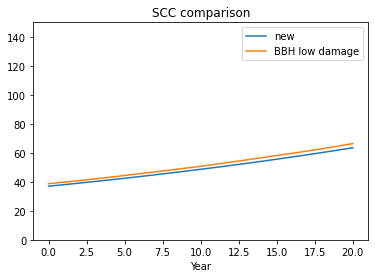

In [124]:
plt.plot(SCCt[:21]*1000, label='new')
plt.plot(scc_low, label='BBH low damage')
plt.ylim(0, 150)
plt.xlabel('Year')
plt.legend()
plt.title('SCC comparison')
plt.savefig('scc.pdf')

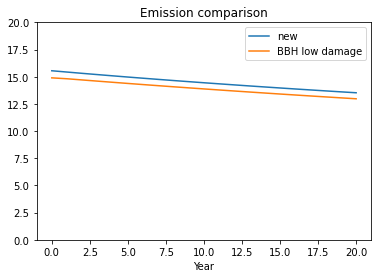

In [71]:
plt.plot(Et[:21], label='new')
plt.plot(emission_low, label='BBH low damage')
plt.ylim(0, 20)
plt.xlabel('Year')
plt.legend()
plt.title('Emission comparison')
plt.savefig('emission.pdf')

In [66]:
emission_low = np.array([emission_bbh[0]['y'][4*i] for i in range(21)])